<a href="https://colab.research.google.com/github/yannberger/yannberger/blob/main/Cryptobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install python-binance

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 288 kB 10.7 MB/s 
     |████████████████████████████████| 103 kB 53.2 MB/s 
     |████████████████████████████████| 1.1 MB 36.2 MB/s 
     |████████████████████████████████| 214 kB 43.4 MB/s 
     |████████████████████████████████| 271 kB 71.9 MB/s 
     |████████████████████████████████| 192 kB 49.3 MB/s 
     |████████████████████████████████| 160 kB 68.5 MB/s 


In [3]:
pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=f74c3b63576a535e81ccd3bb3a20e9faac6c5a313ee5c4aa6ffde3de536f3a0a
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


In [4]:
pip install pandas_ta

     |████████████████████████████████| 115 kB 5.0 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=d0e1cd95361cde365c2b26c4c4f63a6ea40dda2ff999375f91d4846624232942
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


# Import Dataset

In [5]:
import pandas as pd
from binance.client import Client
import ta
import pandas_ta as pda
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored

client = Client()

klinesT = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, "01 january 2021")

df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']
print(df)

# ----- Functions Definition -------
def get_chop(high, low, close, window):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    ci = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)

                        open     high  ...        tb_quote_av  ignore
timestamp                              ...                           
2021-01-01 00:00:00   736.42   739.00  ...  11015918.97221470       0
2021-01-01 01:00:00   734.08   749.00  ...  20362373.93350290       0
2021-01-01 02:00:00   748.27   749.00  ...  13207123.35208410       0
2021-01-01 03:00:00   744.06   747.23  ...   7079926.31087480       0
2021-01-01 04:00:00   744.87   747.09  ...   7539500.28687210       0
...                      ...      ...  ...                ...     ...
2021-11-10 14:00:00  4792.39  4868.00  ...  97123907.50006910       0
2021-11-10 15:00:00  4845.25  4856.59  ...  36218200.90097100       0
2021-11-10 16:00:00  4846.94  4864.84  ...  42848120.63942400       0
2021-11-10 17:00:00  4846.06  4854.27  ...  26485912.12482600       0
2021-11-10 18:00:00  4839.12  4840.80  ...  28443985.13889500       0

[7518 rows x 11 columns]


# Backtest Execution (MM simple, MM exponentielle, RSI, MACD, Stoch RSI, Ichimoku, Bollinger bands, ATR, Supertrend etc.) 

In [8]:
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

#Simple Moving Average
# df['SMA']=ta.trend.sma_indicator(df['close'], window=12)

#Exponential Moving Average
df['EMA1']=ta.trend.ema_indicator(close=df['close'], window=13)
df['EMA2']=ta.trend.ema_indicator(close=df['close'], window=38)

# #Relative Strength Index (RSI)
# df['RSI'] =ta.momentum.rsi(close=df['close'], window=14)

# #MACD
# MACD = ta.trend.MACD(close=df['close'], window_fast=12, window_slow=26, window_sign=9)
# df['MACD'] = MACD.macd()
# df['MACD_SIGNAL'] = MACD.macd_signal()
# df['MACD_DIFF'] = MACD.macd_diff() #Histogramme MACD

# #Stochastic RSI
# df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3) #Non moyenné 
# df['STOCH_RSI_D'] = ta.momentum.stochrsi_d(close=df['close'], window=14, smooth1=3, smooth2=3) #Orange sur TradingView
# df['STOCH_RSI_K'] =ta.momentum.stochrsi_k(close=df['close'], window=14, smooth1=3, smooth2=3) #Bleu sur TradingView

# #Ichimoku
# df['KIJUN'] = ta.trend.ichimoku_base_line(high=df['high'], low=df['low'], window1=9, window2=26)
# df['TENKAN'] = ta.trend.ichimoku_conversion_line(high=df['high'], low=df['low'], window1=9, window2=26)
# df['SSA'] = ta.trend.ichimoku_a(high=df['high'], low=df['low'], window1=9, window2=26)
# df['SSB'] = ta.trend.ichimoku_b(high=df['high'], low=df['low'], window2=26, window3=52)

# #Bollinger Bands
# BOL_BAND = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
# df['BOL_H_BAND'] = BOL_BAND.bollinger_hband() #Bande Supérieur
# df['BOL_L_BAND'] = BOL_BAND.bollinger_lband() #Bande inférieur
# df['BOL_MAVG_BAND'] = BOL_BAND.bollinger_mavg() #Bande moyenne

# #Average True Range (ATR)
# df['ATR'] = ta.volatility.average_true_range(high=df['high'], low=df['low'], close=df['close'], window=14)

# #Super Trend
# ST_length = 10
# ST_multiplier = 3.0
# superTrend = pda.supertrend(high=df['high'], low=df['low'], close=df['close'], length=ST_length, multiplier=ST_multiplier)
# df['SUPER_TREND'] = superTrend['SUPERT_'+str(ST_length)+"_"+str(ST_multiplier)] #Valeur de la super trend
# df['SUPER_TREND_DIRECTION'] = superTrend['SUPERTd_'+str(ST_length)+"_"+str(ST_multiplier)] #Retourne 1 si vert et -1 si rouge

# #Awesome Oscillator
# df['AWESOME_OSCILLATOR'] = ta.momentum.awesome_oscillator(high=df['high'], low=df['low'], window1=5, window2=34)

# # Kaufman’s Adaptive Moving Average (KAMA)
# df['KAMA'] = ta.momentum.kama(close=df['close'], window=10, pow1=2, pow2=30)

# #Choppiness index
# df['CHOP'] = get_chop(high=df['high'], low=df['low'], close=df['close'], window=14)  

df

,open,high,low,close,volume,EMA1,EMA2,RSI
timestamp,,,,,,,,
2021-01-01 00:00:00,736.42,739.00,729.33,734.07,27932.69884000,NaN,NaN,NaN
2021-01-01 01:00:00,734.08,749.00,733.37,748.28,52336.18779000,NaN,NaN,NaN
2021-01-01 02:00:00,748.27,749.00,742.27,744.06,33019.50100000,NaN,NaN,NaN
2021-01-01 03:00:00,744.06,747.23,743.10,744.82,17604.80859000,NaN,NaN,NaN
2021-01-01 04:00:00,744.87,747.09,739.30,742.29,18794.15424000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-11-10 14:00:00,4792.39,4868.00,4791.22,4845.24,37726.30283000,4751.269709,4746.259477,64.463837
2021-11-10 15:00:00,4845.25,4856.59,4831.51,4846.71,15779.65280000,4764.904036,4751.410786,64.621001
2021-11-10 16:00:00,4846.94,4864.84,4833.19,4846.05,23144.97720000,4776.496317,4756.264079,64.483109


# Spot Backtest

Period : [2021-01-01 00:00:00] -> [2021-11-10 18:00:00]
Starting balance : 1000 $
Final balance : 2485.39 $
Performance vs US Dollar : 148.54 %
Buy and Hold Performence : 553.06 %
Performance vs Buy and Hold : -73.14 %
Number of negative trades :  66
Number of positive trades :  29
Average Positive Trades :  7.92 %
Average Negative Trades :  -1.83 %
Best trade +9.95 %, the  2021-05-24 15:00:00
Worst trade -2.05 %, the  2021-05-30 22:00:00
Worst drawBack -27.0 %
Total fee :  227.23 $
Buy Market number : 96
Sell Stop Loss number : 51
Sell Take Profit number : 21
Sell Market number : 23
PLOT


,date,position,reason,price,frais,fiat,coins,wallet,drawBack,resultat,resultat%,tradeIs
date,,,,,,,,,,,,
2021-01-02 13:00:00,2021-01-02 13:00:00,Buy,Buy Market,770.7700,0.700000,0,1.296496,999.300000,0.000000,NaN,NaN,
2021-01-02 14:00:00,2021-01-02 14:00:00,Sell,Sell Stop Loss,755.3546,0.489657,978.824,0.000000,978.824343,-0.020490,-20.475657,-2.049000,Bad
2021-01-09 08:00:00,2021-01-09 08:00:00,Buy,Buy Market,1208.0100,0.685177,0,0.809711,978.139166,-0.021176,NaN,NaN,
2021-01-10 01:00:00,2021-01-10 01:00:00,Sell,Sell Take Profit,1328.8110,0.537977,1075.42,0.000000,1075.415106,0.000000,97.275940,9.945000,Good
2021-01-13 19:00:00,2021-01-13 19:00:00,Buy,Buy Market,1102.0800,0.752791,0,0.975122,1074.662315,-0.000700,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-05 07:00:00,2021-11-05 07:00:00,Buy,Buy Market,4529.3500,1.701280,0,0.536214,2428.699265,-0.155091,NaN,NaN,
2021-11-05 10:00:00,2021-11-05 10:00:00,Sell,Sell Market,4499.9900,0.906336,2412.05,0.000000,2412.049696,-0.160883,-16.649569,-0.685534,Bad
2021-11-07 00:00:00,2021-11-07 00:00:00,Buy,Buy Market,4544.9800,1.688435,0,0.530335,2410.361261,-0.161470,NaN,NaN,


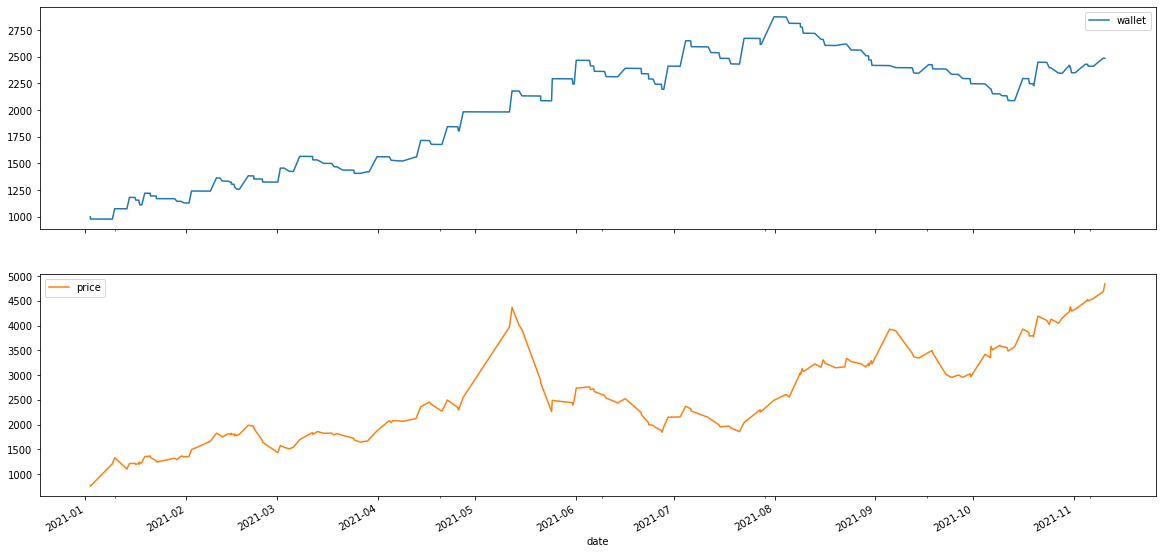

In [7]:
dfTest = df.copy()
# dfTest = df['2021-01-01':]
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
previousRow = dfTest.iloc[0]
makerFee = 0.0005
takerFee = 0.0007
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True

def buyCondition(row, previousRow):
  if row['EMA1'] > row['EMA2']:
    return True
  else:
    return False

  
def sellCondition(row, previousRow):
  if row['EMA2'] > row['EMA1']:
    return True
  else:
    return False


for index, row in dfTest.iterrows():
  #Buy market order
  if buyCondition(row, previousRow) == True and usdt > 0 and buyReady == True:
    #You can define here at what price you buy
    buyPrice = row['close']

    #Define the price of you SL and TP or comment it if you don't want a SL or TP
    stopLoss = buyPrice - 0.02 * buyPrice
    takeProfit = buyPrice + 0.1 * buyPrice

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
      lastAth = wallet

    # print("Buy COIN at",buyPrice,'$ the', index)
    myrow = {'date': index,'position': "Buy", 'reason': 'Buy Market','price': buyPrice,'frais': fee*row['close'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  #Stop Loss
  elif row['low'] < stopLoss and coin > 0:

    sellPrice = stopLoss

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Stop Loss', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Take Profit
  elif row['high'] > takeProfit and coin > 0:

    sellPrice = takeProfit

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Take Profit Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Take Profit', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)     

  # Sell Market
  elif sellCondition(row, previousRow) == True:
    buyReady = True
    if coin > 0 and sellReady == True:
      sellPrice = row['close']
      usdt = coin * sellPrice
      frais = fee * usdt
      usdt = usdt - frais
      coin = 0
      wallet = usdt
      if wallet > lastAth:
        lastAth = wallet
      # print("Sell COIN at",sellPrice,'$ the', index)
      myrow = {'date': index,'position': "Sell", 'reason': 'Sell Market', 'price': sellPrice, 'frais': frais, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
      dt = dt.append(myrow,ignore_index=True)
  
  previousRow = row

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")
reasons = dt['reason'].unique()
for r in reasons:
  print(r+" number :",dt.groupby('reason')['date'].nunique()[r])

dt[['wallet','price']].plot(subplots=True, figsize=(20,10))
print('PLOT')
dt